In [2]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

In [3]:
def strobe(tvec,signal,period):
    n = 0
    strobedSignal = []
    strobedTime = []
    for t in tvec:
        if t % period == 0:
#             print(t)
            strobedTime.append(t)
            strobedSignal.append(signal[n])
        n += 1
    return [strobedTime, strobedSignal]

In [4]:
# compute the rank of a spike train
def sTrainToRank(sTrain, delta_t, duration):
    """
    This function takes a spike train as input (a list of times when spikes occur)
    and returns a rank for that spike train by converting it to a binary sequence
    and converting that to a base 10 number.
    
    For example, a spike train sTrain = np.array([0.5,1.3,3.4,6.7,8.9,9.3]) would
    get converted to the string 1101001011 if a time bin delta_t=1 was used. This
    binary string would then be converted to 843 in base 10.
    
    sTrain = the list of spike times
    delta_t = the size of the time bin
    duration = the length of the time series to consider
    """
    Ts = int(duration) # consider time sequences of length 4*ms

    binTrain = np.zeros(Ts//delta_t)
    count = 0
    for j in range(len(binTrain)):
        state = int(0)
        for s in sTrain:
            condition = (s >= j*delta_t and s < (j+1)*delta_t)
            if condition:
                state = 1
                count += 1 # spike count
        binTrain[j] = int(state)

    # convert the list binTrain to a string
    
    binTrainStr=""
    for i in binTrain:
        binTrainStr += str(int(i))

    # convert the binary sequence to a number in base 10
    binTrainBase10 = int(binTrainStr, 2)
    ret = [binTrainBase10, binTrainStr, count]
    return ret

sTrain = np.array([0.5,1.3,3.4,6.7,8.9,9.3])
delta_t = 1
duration = 10
binTrainBase10, binTrainStr, count = sTrainToRank(sTrain, delta_t, duration)
print(binTrainBase10)
print(binTrainStr)
print(f'spike count = {count}')

843
1101001011
spike count = 6


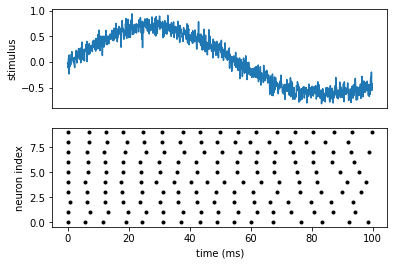

In [13]:
start_scope()
duration = 100*ms
dt = defaultclock.dt
tVec = np.arange(0,duration/ms+dt/ms,dt/ms)
noise = np.random.normal(0,0.1,len(tVec))
f1 = 5*Hz # frequency of I(t) in (Hz)
f2 = 10*Hz
f3 = 2*Hz
det = 0.5*np.sin(2*np.pi*tVec*f1/(1000*Hz)) + 0.5*np.sin(2*np.pi*tVec*f2/(1000*Hz)) - 0.5*np.sin(2*np.pi*tVec*f3/(1000*Hz))
signal = det + noise
# signal = noise
In = TimedArray(signal,dt)

tau = 10*ms
eqs = '''
dv/dt = (1-v+In(t))/tau : 1 (unless refractory)
'''

G = NeuronGroup(10, eqs, threshold='v>rand()', reset='v=0', refractory = 5*ms, method='exact')
G.v = 'rand()'
M = StateMonitor(G, ['v'], record=True)
S = SpikeMonitor(G)
run(duration)

fig, ax = plt.subplots(2,1)
ax[0].plot(tVec, signal)
ax[0].set_xticks([])
ax[0].set_ylabel('stimulus')
# ax[1].plot(M.t/ms, M.v[0])
ax[1].plot(S.t/ms,S.i,marker='o',linestyle='',color='black',markersize=3)
ax[1].set_ylabel('neuron index')
ax[1].set_xlabel('time (ms)')
plt.show()

In [44]:
# max(S.i)
T=50
delta_t = 5
stimVec = strobe(tVec,signal,T)[1]
ranks = np.zeros((max(S.i)+1,len(stimVec)))
counts = np.zeros((max(S.i)+1,len(stimVec)))

for nrn in range(max(S.i)+1):
    stOG = S.t[S.i==nrn]/ms
    st = S.t[S.i==nrn]/ms % T

    n0 = 0
    j = 0 # counter through time
    for n in range(len(st)-1):
        if st[n+1] < st[n]:
            sub_st = st[n0:n+1]
    #         print(sub_st)
            binTrainBase10, binTrainStr, count = sTrainToRank(sub_st, delta_t, T)
            print(f'{sub_st} = {binTrainStr} has rank {binTrainBase10} and spike count = {count}')
            ranks[nrn][j] = binTrainBase10
            counts[nrn][j] = count
            n0 = n+1
            j+=1
        if stOG[n+1] > duration/ms - T:
    #         print(stOG[n+1])
            sub_st = st[n+1:]
            binTrainBase10, binTrainStr, count = sTrainToRank(sub_st, delta_t, T)
            print(f'{sub_st} = {binTrainStr} has rank {binTrainBase10} and spike count = {count}')
            ranks[nrn][j] = binTrainBase10
            counts[nrn][j] = count
            break
            
ranks.shape

[ 0.   5.8 11.7 19.  24.5 31.2 37.  43.4 49. ] = 1111101111 has rank 1007 and spike count = 9
[ 4.7 10.1 17.4 26.4 33.3 42.2 48.6] = 1011011011 has rank 731 and spike count = 7
[ 0.   7.2 13.3 19.9 25.8 31.4 37.8 43.8 49.3] = 1111011111 has rank 991 and spike count = 9
[ 6.  12.  17.3 23.3 30.9 37.1 44.1] = 0111101110 has rank 494 and spike count = 7
[ 0.9  6.5 12.1 18.2 23.6 30.2 36.1 42.3 48.1] = 1111101111 has rank 1007 and spike count = 9
[ 4.5 11.1 16.4 22.4 29.7 36.3 43.7] = 1011110110 has rank 758 and spike count = 7
[ 0.   6.2 12.4 17.7 24.3 31.1 36.3 42.1 48.5] = 1111101111 has rank 1007 and spike count = 9
[ 4.7 10.9 18.7 26.1 33.  39.9 46.2] = 1011011101 has rank 733 and spike count = 7
[ 0.1  5.6 12.2 17.5 23.9 29.1 34.8 40.3 45.8] = 1111111011 has rank 1019 and spike count = 9
[ 1.4  7.4 13.4 19.4 26.  31.6 41.7 47.9] = 1111011011 has rank 987 and spike count = 8
[ 0.   6.6 12.6 18.3 24.2 30.2 35.7 42.3 49. ] = 1111101111 has rank 1007 and spike count = 9
[ 5.6 12.2 17.5 2

(10, 3)

In [27]:
def computeSMI(X, Y, m, k):
    '''
    computes the sliced mutual information (see Goldfeld & Greenewald 2021)
        between X and Y with m slices.
    Assumes X has shape (dimX) X (obs) and Y has shape (dimY) X (obs) where
        'obs' is the number of observations.
    This code uses the KSG method for estimating mutual information, imported
        from sklearn.feature_selection
    '''
    dimX = X.shape[0]
    dimY = Y.shape[0]
    SMI = 0
    for mi in range(m):
        Theta = np.random.uniform(0,1,dimX)
        Phi = np.random.uniform(0,1,dimY)
        newX = np.dot(Theta,X)
        newX = np.reshape(newX, (len(newX),1))
        newY = np.dot(Phi,Y)
        Si = mutual_info_regression(newX, newY, n_neighbors=k)[0]
        SMI += Si/np.log(2)
    SMI = SMI/m
    return SMI

In [32]:
X = counts + np.random.normal(0,10**(-4),(max(S.i)+1,len(stimVec)))
print(X.shape)
# print(len(X))
# X = np.reshape(X, (1,len(X)))
Y = np.array(stimVec)
# print(len(Y))
Y = np.reshape(Y, (1,len(Y)))
m=5
k=1
MIfunc = computeSMI(X,Y,m,k)
print(MIfunc)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9398c501f0>
Traceback (most recent call last):
  File "/home/zmobille3/anaconda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmobille3/anaconda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmobille3/anaconda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmobille3/anaconda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<loc

(10, 3)
0.24044917348149397


In [40]:
numObs = counts.shape[0]*counts.shape[1]
numObs

30

In [55]:
#### SLICED MI USED HERE ####

m=3
k=1
SCs = np.unique(counts) # all observed spike counts
numObs = counts.shape[0]*counts.shape[1] # total number of spike count observations
# SCs = [1]
# print(SCs)
MItemp = 0
for sc in SCs:
    print(f'spike count = {sc}')
#     idx = np.nonzero(counts==sc)[0]
    idx = np.nonzero(counts==sc)
    print(idx)
#     probSC = len(idx[0])/numObs
# #     print(len(idx[0]))
# #     probSC = len(idx)/len(countVec)
#     print(f'probability of spike count = {sc} is {probSC}')
# #     print(ranks[idx])
#     x = ranks[idx]
#     x = np.reshape(x,(len(x),1))
#     y = np.array(stimVec)
#     y = y[idx]
#     X = np.reshape(x, (1,len(x)))
#     Y = np.reshape(y, (1,len(y)))
#     if len(x)>1: # don't use sub-samples with only 1 element
#         mi = computeSMI(X,Y,m,k)
#         print(f'\tconditional timing MI = {mi}')
#         MItemp += probSC*mi
# print(f'temporal MI = {MItemp}')

#     for nrn in range(max(S.i)+1):
#         x = ranks[idx]
#         print(x)
#     print(rankVec[idx[0]])
# #     x = np.reshape(x,(len(x),1))
#     y = np.array(stimVec)
#     y = y[idx]
#     X = np.reshape(x, (1,len(x)))
#     Y = np.reshape(y, (1,len(y)))
#     if len(x)>1: # don't use sub-samples with only 1 element
# #         mi = mutual_info_regression(x, y, n_neighbors=1)[0]
#         mi = computeSMI(X,Y,m,k)
#         print(f'\tconditional timing MI = {mi}')
#         MItemp+=probSC*mi
# print(f'temporal MI = {MItemp}')
#     print(rankVec[idx])

spike count = 0.0
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))
spike count = 7.0
(array([0, 1, 2, 3, 5, 6, 8]), array([1, 1, 1, 1, 1, 1, 1]))
spike count = 8.0
(array([4, 7, 9]), array([1, 0, 0]))
spike count = 9.0
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1]))


In [54]:
stimVec

[-0.024908170592113473, 0.265114702058159, -0.4213762950487997]

In [65]:
#### NO SLICED MI USED HERE ####

SCs = np.unique(countVec) # all observed spike counts
# print(SCs)
MItemp = 0
for sc in SCs:
    print(f'spike count = {sc}')
#     idx = np.argwhere(countVec==sc)[:,0]
#     idx = np.argwhere(countVec==sc)
    idx = np.nonzero(countVec==sc)[0]
    probSC = len(idx)/len(countVec)
    print(f'probability of spike count = {sc} is {probSC}')
    x = rankVec[idx]
#     print(rankVec[idx])
    x = np.reshape(x,(len(x),1))
    y = np.array(stimVec)
    y = y[idx]
    if len(x)>1: # don't use sub-samples with only 1 element
        mi = mutual_info_regression(x, y, n_neighbors=1)[0]
        print(f'\tconditional timing MI = {mi}')
        MItemp+=probSC*mi
print(f'temporal MI = {MItemp}')
#     print(rankVec[idx])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb2e3d98310>
Traceback (most recent call last):
  File "/home/zmobille3/anaconda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmobille3/anaconda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmobille3/anaconda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmobille3/anaconda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


spike count = 0.0
probability of spike count = 0.0 is 0.48514851485148514
	conditional timing MI = 1.1102230246251565e-16
spike count = 1.0
probability of spike count = 1.0 is 0.0297029702970297
	conditional timing MI = 0
spike count = 2.0
probability of spike count = 2.0 is 0.0891089108910891
	conditional timing MI = 0.9085978835978836
spike count = 3.0
probability of spike count = 3.0 is 0.07920792079207921
	conditional timing MI = 0.9470238095238095
spike count = 4.0
probability of spike count = 4.0 is 0.19801980198019803
	conditional timing MI = 0.13180531370933857
spike count = 5.0
probability of spike count = 5.0 is 0.0594059405940594
	conditional timing MI = 0
spike count = 6.0
probability of spike count = 6.0 is 0.0594059405940594
	conditional timing MI = 0
temporal MI = 0.18207601685899213
